In [ ]:
import matlab.engine

eng = matlab.engine.start_matlab()

In [21]:
import os

numRX = 4
numADCSamples = 512
numADCBits = 16


for item in os.listdir("data/raw_data"):
    if (item[-4:] == ".bin") & (item[:3]!="adc") & ((item[:-4] + "_amplitude.csv") not in os.listdir("data/matlab_processed_data")):
        # print(item)
        eng.reading_bin_file("data/raw_data/{}" .format(item), "{}" .format(item[:-4]), numRX, numADCBits, numADCSamples, nargout=0)



In [51]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.fft import fft
import matplotlib

from scipy.signal import butter, filtfilt

numRX = 4
numADCSamples = 512
numADCBits = 16



def butter_bandpass(lowcutoff, highcutoff, fs, order):
    """
    This function takes in the filter parameters and
    does the simple calculations needed to account for the
    Nyquist frequency and using the scipy butter function
    to produce the numerator and polynomials of the IIR filter \n
    Inputs: \n
    1) lowcutoff - lower frequecy cutoff of bandpass filter
    2) highcutoff - upper frequecy cutoff of bandpass filter
    3) fs - sampling frequency
    4) order - filter order \n
    Outputs: \n
    1) a - denominator polynomials of the IIR filter
    2) b - numerator polynomials of the IIR filter

    """
    nyq = 0.5 * fs  #nyquist frequency
    lowcutoff = lowcutoff / nyq        
    highcutoff = highcutoff / nyq
    a,b = butter(order, [lowcutoff, highcutoff], analog=False, btype='bandpass',output = 'ba')
    return a,b

def butter_bandpass_filter(data, lowcutoff, highcutoff, fs, order):
    """
    This function wraps the scipy functions needed to implement a 
    bandpass fillter and ultimately filters the signal \n
    Inputs: \n
    1) data - signal to be filtered
    2) lowcutoff - lower frequecy cutoff of bandpass filter
    3) highcutoff - upper frequecy cutoff of bandpass filter
    4) fs - sampling frequency
    5) order - filter order \n
    Outputs: \n
    1) filtered_signal

    """
    a,b = butter_bandpass(lowcutoff, highcutoff, fs, order=order)
    filtered_signal = filtfilt(a,b, data)
    
    return filtered_signal

def bandpass_filter(low, high, fs,order, signal, quiet, xlab="", ylab=""):
    """
    This function bandpasses filters a given signal and has an option
    of plotting what the signal looks like before and after filtering \n
    Inputs: \n
    1) low - lower frequecy cutoff of bandpass filter
    2) high - upper frequecy cutoff of bandpass filter
    3) fs - sampling frequency
    4) order - filter order 
    5) signal - signal to be filtered
    6) quiet - (default: False) boolean indicating whether or not to display signal before and after filtering \n
    Outputs: \n
    1) filtered_data

    """
    
    filtered_data = butter_bandpass_filter(signal, low, high, fs, order)

    if quiet == False:    
        plt.figure(figsize = (8,8))
        plt.plot(signal, label='Raw signal')
        plt.title("Unfiltered signal", size = 10)
        plt.xlabel(xlab, size = 10)
        plt.ylabel(ylab, size = 10)

        plt.figure(figsize = (8,8))
        plt.plot(filtered_data)
        plt.title("Bandpass Filtered Signal, Cutoff = {}-{} Hz" .format(low,high), size = 10)
        plt.xlabel(xlab, size = 10)
        plt.ylabel(ylab, size = 10)

    return filtered_data

def avg_IF(case, rx0_chirps):
    plt.figure()
    print("hello")
    plt.plot(rx0_chirps[100,:])
    plt.title("Avg Chirp of {}" .format(case))
    plt.xlabel("ADC Sample Number")
    plt.ylabel("Amplitude of IF Signal (???)")
    plt.savefig("figures/avg_IF_{}.jpeg" .format(case))
    plt.close()

def gen_fft(case, rx0_chirps):
    plt.figure()
    myfft = np.abs(fft(rx0_chirps[12,:]))[:128]   
    plt.plot(np.abs(fft(rx0_chirps[12,:]))[:128])
    plt.title("FFT of ADC for {}" .format(case))
    plt.xlabel("Frequency")
    plt.ylabel("Amplitude")
    plt.savefig("figures/fft_{}.jpeg" .format(case))
    plt.close()

def give_summary(case, amplitude, phase):
    # pdf = matplotlib.backends.backend_pdf.PdfPages("{}_report.pdf")

    amplitude_T  = np.array(amplitude).T
    angle = np.array(phase).T
    rx0 = amplitude_T[0,:]
    rx0angle = angle[0,:]
    rx0_chirps = np.reshape(rx0, (int(np.shape(rx0)[0]/256), 256))
    rx0_chirps_angle = np.reshape(rx0angle, (int(np.shape(rx0angle)[0]/256), 256))

    # gen_fft(case, rx0_chirps)

    avg_IF(case, rx0_chirps)
    

In [46]:
numADCSamples = 512
adc_start_time = 3
sampling_rate = 1e7
sample_period = (1/sampling_rate) 
freq_slope = 65.033 # MHz/us
adc_period = sample_period * numADCSamples * 1e6
starting_freq = adc_start_time*freq_slope + 77e3
ending_freq = (adc_start_time+adc_period) * freq_slope + starting_freq
tx_chirp = np.arange(starting_freq, ending_freq, 1/numADCBits)

In [37]:
print(starting_freq)
print(ending_freq)

77195.099
79055.0428


In [ ]:
eng.close()

In [38]:
import numpy as np
import pandas as pd
import os
from collections import defaultdict

my_data = defaultdict(lambda:defaultdict(str))

In [52]:


for item in os.listdir("data/matlab_processed_data"):
    name_end = item.index(".")
    
    if "exp2" in item:
        if "csv" not in item:
            continue
        if "amplitude" in item:
            my_data[item[:-13]]["amplitude"] = pd.read_csv("data/matlab_processed_data/{}" .format(item), delimiter=",", header=None, dtype=np.float64).T.values
        if "phase" in item:
            my_data[item[:-9]]["phase"] = pd.read_csv("data/matlab_processed_data/{}" .format(item), delimiter=",", header=None, dtype=np.float64).T.values
    
    # if (item[-13:] == "amplitude.csv") and (item[:-13] not in my_data):
    #     my_data[item[:-13]]["amplitude"] = np.array(pd.read_csv("data/matlab_processed_data/{}" .format(item), delimiter=",", header=None, dtype=np.float64)).T
    # else:
    #     continue
    #     my_data[item[:-9]]["phase"] = np.array(pd.read_csv("data/matlab_processed_data/{}" .format(item), delimiter=",", header=None, dtype=np.float64)).T
    #     # give_summary(item[:-4], amplitude, phase)

(8192000,)


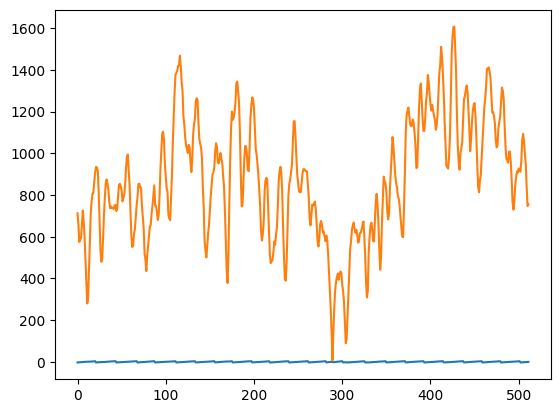

: 

In [60]:
phase = my_data["test_exp2_"]["phase"][1]
ampl = my_data["test_exp2_"]["amplitude"][1]
print(np.shape(ampl))
plt.plot(phase[:512])
plt.plot(ampl[:512])

In [44]:

# amp = my_data["random_trial_"]["amplitude"]
# rx0 = amp[0,:]
# data = bandpass_filter(1, 4e6, 1e7, 1, data, True)
# frame_1 = rx0[:numADCSamples]
# plt.figure(figsize=(12,5))
# plt.plot(frame_1)

my_data.keys()

dict_keys(['absorber_exp_', 'empty_hallway_', 'goldbox_1_5_m_', 'goldbox_1_m_', 'goldbox_2_m_', 'phone_1_5m_quite_', 'phone_1_5m_wolfram_', 'phone_1_m_quite_', 'phone_1_m_wolfram_Raw_0_', 'phone_2m_quite_', 'phone_2m_wolfram_', 'random_trial_', 'table_1_5_m_', 'table_1_m_Raw_0_', 'table_2_m_', 'test_exp_', 'test_exp_ampl', 'test_exp'])

In [18]:
np.shape(my_data["test_exp_"]["amplitude"])[1]

8192000

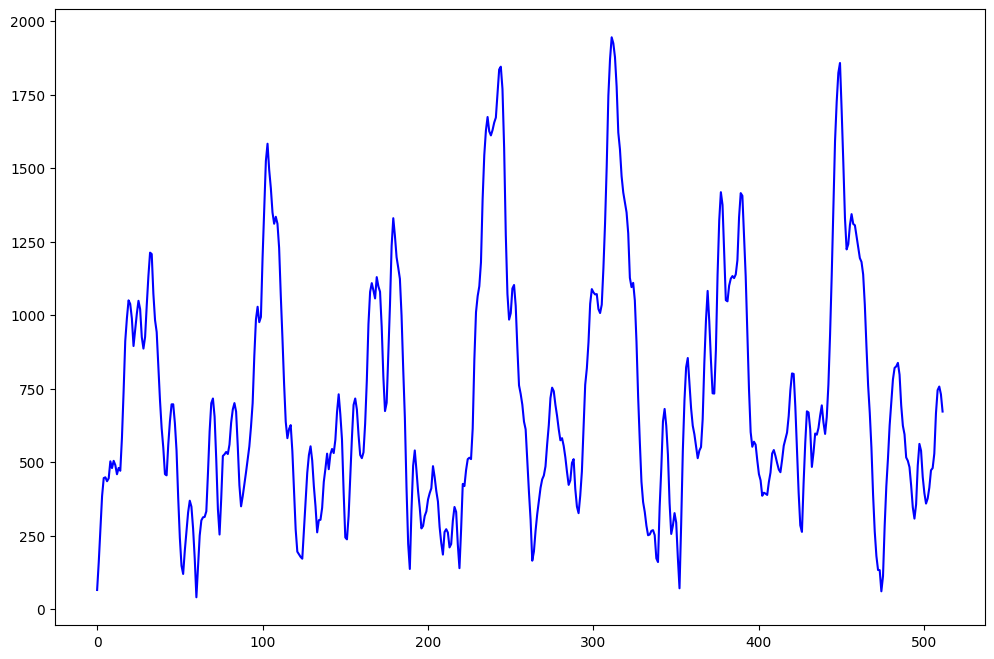

In [49]:
amp = my_data["test_exp_"]["amplitude"]
# phase = my_data["test_exp_"]["phase"]

rx0 = amp[0,:]
# rx0_phase = phase[0,:]

plt.figure(figsize=(12,8))
plt.plot(rx0[:512], c="blue")
# plt.plot(rx0_phase[:512], c="red")

In [38]:
from scipy.fft import fft, fftfreq
import matplotlib.backends.backend_pdf
from scipy.integrate import cumtrapz
from scipy.signal import find_peaks

dbfs=False

for exp in ["yes_phone", "no_phone"]:
    pdf = matplotlib.backends.backend_pdf.PdfPages("range_fft_{}_hallways_report.pdf".format(exp))
    cutoff = 5
    for experiment in my_data.keys():
        if ("emp" in experiment):
            continue
        if exp == "no_phone":
            if "phone" in experiment:
                continue
        else:
            if "phone" not in experiment:
                continue
        amp = my_data[experiment]["amplitude"]
        
        rx0 = amp[0,:]
        
        rx0_chirps = np.reshape(rx0, (int(np.shape(rx0)[0]/numADCSamples), numADCSamples))
        fig = plt.figure(figsize=(12,8))
        plt.title(experiment)
        
        data = rx0_chirps[20,:]#.flatten()

        # data = bandpass_filter(1, 4e6, 1e7, 1, data, True)
        # print(data.size)
        # data = rx0_chirps[10,:]
        # print(len(np.abs(fft(data, n=numADCSamples*4))))
        data = np.abs(fft(data, n=numADCSamples*4))[:int(numADCSamples*2)]
        
        if dbfs:
            
            data = 20 * np.log10(data[cutoff:]/np.max(data[cutoff:]))
            
            mypeaks = find_peaks(data, prominence=8, distance=1)[0]
              
            mypeaks = mypeaks[mypeaks < int(0.5*len(data))]
            # data = data-emp_fft
            dist = (fftfreq(numADCSamples*4,1/1e7)[:numADCSamples*2] * 3e8 * (1/30e12))[cutoff:]
            print(dist) 
            plt.plot(dist, data)
            
            plt.plot(dist[mypeaks], data[mypeaks], "o", c = "red")
            count = 0
            
            for peak in list(mypeaks):
                if count > 3:
                    break
                count += 1
                plt.text(dist[peak], data[peak]+5, str(round(dist[peak],2))+"m", fontsize="small")
            
            pdf.savefig(fig)
            plt.xlim((0,5))
            plt.close()
        else:
            
            # dist = (fftfreq(numADCSamples*4,1/1e7)[:numADCSamples//2] * 3e8 * (1/30e12))[:]            
            dist = (fftfreq(numADCSamples*4,1/1e7)[:numADCSamples*2] * 3e8 * (1/30e12))#[cutoff:]
            plt.plot(dist,data)
            plt.xlim((0,5))
            pdf.savefig(fig)
            plt.close()


    pdf.close()


In [36]:
amplitude_T  = np.array(amplitude).T
# angle = np.array(phase).T
rx0 = amplitude_T[0,:]
# rx0angle = angle[0,:]
rx0_chirps = np.reshape(rx0, (int(np.shape(rx0)[0]/numADCSamples), numADCSamples))
# rx0_chirps_angle = np.reshape(rx0angle, (int(np.shape(rx0angle)[0]/256), 256))

amplitude_T  = np.array(amplitude2).T
# angle = np.array(phase).T
rx0 = amplitude_T[0,:]

# rx0angle = angle[0,:]
rx0_chirps2 = np.reshape(rx0, (int(np.shape(rx0)[0]/numADCSamples), numADCSamples))